# 1. Import and Hyper-Parameters

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from functions import method_position_independent

In [3]:
input_folder = 'd:\\15 CT_data\\CPU_test\\'
output_folder = 'd:\\15 CT_data\\CPU_test\\result'
ROI = '400'
method_name = 'otsu'
resize_dims = '0'

In [4]:
img_files = sorted([os.path.join(input_folder, f) for f in os.listdir(input_folder)
                    if f.endswith('.bmp') or f.endswith('.png')])
radius = int(ROI)

In [15]:
def adjust_gamma(image, gamma=1.0):
    # 建立查找表
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")

    # 应用伽马校正
    return cv2.LUT(image, table)


def calculate_hist(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    return hist


def calculate_pore(image):
    _, dst = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)
    pore = np.sum(dst/255) / dst.shape[0] / dst.shape[1]
    return pore


# 2. Read Image

In [6]:
test_img = cv2.imread(img_files[0], cv2.IMREAD_GRAYSCALE)
height, width = test_img.shape
test_img = test_img[(height // 2 - radius):(height // 2 + radius), (width // 2 - radius):(width // 2 + radius)]

# 3. Hist

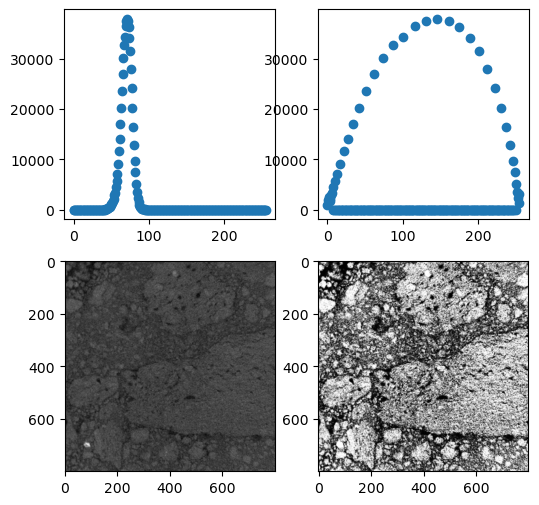

In [7]:
test_img_hist = calculate_hist(test_img)
test_img_equalized = cv2.equalizeHist(test_img)
test_img_equalized_hist = calculate_hist(test_img_equalized)

plt.figure(figsize=(6, 6))

plt.subplot(2, 2, 1)
plt.scatter(np.arange(256), test_img_hist)
plt.subplot(2, 2, 2)
plt.scatter(np.arange(256), test_img_equalized_hist)
plt.subplot(2, 2, 3)
plt.imshow(test_img, cmap='gray')
plt.subplot(2, 2, 4)
plt.imshow(test_img_equalized, cmap='gray')


In [16]:
pore_original = calculate_pore(test_img)
pore_equalized = calculate_pore(test_img_equalized)
print(f"pore_original: {pore_original}\npore_equalized: {pore_equalized}")

pore_original: 0.5466546875
pore_equalized: 0.5466546875


# 4. Threshold

In [12]:
gamma_adjusted = adjust_gamma(test_img, gamma=1)
_, dst = cv2.threshold(gamma_adjusted, 0, 255, cv2.THRESH_OTSU)
pore = calculate_pore(dst)
print(pore)

cv2.namedWindow('threshold', cv2.WINDOW_NORMAL)
cv2.imshow('threshold', dst)
cv2.waitKey(0)
cv2.destroyAllWindows()

0.5466546875
